In [1]:
from hcipy import *
import matplotlib.pyplot as plt
import numpy as np
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

In [2]:
wavelength = 633e-9
lam_d = .633
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8, 12)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

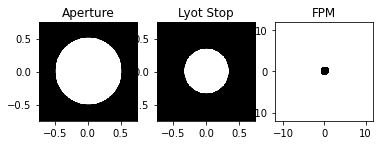

In [3]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(.67), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(3*lam_d), focal_grid, 4)
fpm = fpm_inverse == 0
plt.subplot(1, 3, 1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Lyot Stop')
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('FPM')
imshow_field(fpm, cmap='gray')
plt.show()


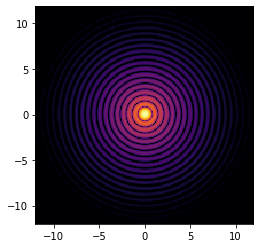

In [4]:
wf = Wavefront(aperture, wavelength=.638)
img_ref = prop(wf).intensity

imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5, cmap='inferno')


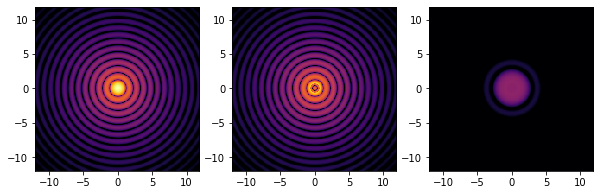

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

perfect_coro = PerfectCoronagraph(evaluate_supersampled(circular_aperture(2*lam_d), focal_grid, 10))
wf = Wavefront(aperture)
img = prop(wf)
img_ref = img.intensity
perfect_focal = perfect_coro(img)
lyot_plane = lyot_coro(wf)
post_lyot_mask = lyot_stop(lyot_plane)
img = prop(post_lyot_mask).intensity

plt.subplot(1, 3, 1)
imshow_field(np.log10(img_ref/img_ref.max()), cmap='inferno', vmin=-5, vmax=0)
plt.subplot(1, 3, 2)
imshow_field(np.log10(perfect_focal.intensity/img_ref.max()), cmap='inferno', vmin=-5, vmax=0)
plt.subplot(1, 3, 3)
imshow_field(np.log10(img /img_ref.max()), cmap='inferno', vmin=-5, vmax=0)


In [6]:
def calculate_raw_contrast(image_data, max_ref=1):
    
    origin = (192/2, 192/2)
    max_edge = int(192/2)
    annulus_width = lam_d/2*(192/10)
    ring_edges = np.arange(annulus_width+.01, max_edge, annulus_width)
    ring_sums = []

    for ring_edge in np.arange(annulus_width+.01, max_edge, annulus_width):
        #print(ring_edge-annulus_width, ring_edge)
        ring = CircularAnnulus(origin, r_in=ring_edge-annulus_width, r_out=ring_edge)
        ring_mask = ring.to_mask(method='center')
        image_ring = ring_mask.multiply(image_data/max_ref)
        ring_sums.append(np.std(image_ring))
    return ring_edges, ring_sums

In [37]:
def generate_coronagraph(fpm_diameter, lyot_diameter, plot=False, vmin=-5, vmax=0, aperture_type='iris', 
                         coronagraph_type='lyot', add_companion=True, companion_position=10, 
                         companion_brightness=0.01, wf=None, ao=False):
    
    pupil_grid = make_pupil_grid(256, 1.5) # this might be totally wrong whoops
    focal_grid = make_focal_grid(8, 12)  # same tho
    circular = evaluate_supersampled(circular_aperture(1), pupil_grid, 6)
    aperture = iris_aperture if aperture_type == 'iris' else circular
    companion_brightness = 0.01 if companion_brightness is None else companion_brightness
    
    lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter), pupil_grid, 4)

    prop = FraunhoferPropagator(pupil_grid, focal_grid)
    
    wf = Wavefront(aperture) if wf is None else wf
    img_ref = prop(wf).intensity
    
    if ao:
        wf = ao.forward(wf)
        img_ref = prop(wf).intensity
        
    
    if add_companion:
        wf = Wavefront(aperture + aperture * companion_brightness * np.exp(complex(0, companion_position) * np.pi * pupil_grid.x * 1.5), wavelength=.638)
        img_ref = prop(wf).intensity
    
    if coronagraph_type == 'lyot':
        fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), focal_grid, 4)
        fpm = fpm_inverse == 0
        coro = LyotCoronagraph(pupil_grid, fpm)
        lyot_stop = Apodizer(lyot_mask)
    
    if coronagraph_type == 'vortex':
        charge = 2
        coro = VortexCoronagraph(pupil_grid, charge)
        lyot_stop = Apodizer(lyot_mask)
    
    pupil_plane = coro(wf)
    post_lyot_mask = lyot_stop(pupil_plane)
    img = prop(post_lyot_mask).intensity
    
    if plot:
        imshow_field(np.log10(img /img_ref.max()), vmin=vmin, vmax=vmax, cmap='inferno')
    return img.shaped, img_ref.max(), img, img_ref

In [8]:
def calculate_throughput(before_corona_image, after_corona_image, companion_position=(135, 96), radius=5):
    
    phot_aperture = CircularAperture([companion_position], r=radius)
    phot_before = aperture_photometry(before_corona_image, phot_aperture)['aperture_sum'][0]
    phot_after = aperture_photometry(after_corona_image, phot_aperture)['aperture_sum'][0]
    
    return phot_before, phot_after, phot_after/phot_before

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/hcipy/util/spectral_noise.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_1 = np.add.reduce(np.ix_(*S_1))
/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/hcipy/util/spectral_noise.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_2 = np.add.reduce(np.ix_(*S_2))


Text(0.5, 1.0, 'Testing varying companion brightness')

<Figure size 432x288 with 0 Axes>

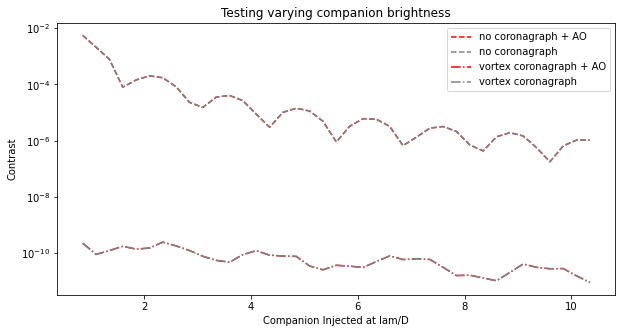

In [38]:
def calculate_contrast_curve(coronagraph, factor=1, include_wfe=False, include_amp_e=False, include_ao=False):
    
    pixel_to_j = (186-96)/35
    lam_d_to_pixel = lam_d/2*(192/10)
    j_increment = .25*lam_d_to_pixel/pixel_to_j # so we place companion at .25 lam/d distances 
    annulus_width = j_increment*pixel_to_j
    
    fpm_diameter, lyot_diameter = coronagraph['fpm_diameter'], coronagraph['lyot_diameter']
    aperture_type, coronagraph_type = coronagraph['aperture_type'], coronagraph['coronagraph_type']
    brightness = coronagraph['companion_brightness']
    
    n_lam_over_d_list, contrast_list = [], []
    
    for j in np.arange(2, 25, j_increment):
        #print(j)
        
        if include_wfe:
            aberration = SurfaceAberration(pupil_grid, .1, 1, exponent=-2)
            wf = Wavefront(aperture)
            wf = aberration(wf)
        else:
            wf = None
        _, _, no_companion_img, _ = generate_coronagraph(fpm_diameter, lyot_diameter, 
                                               plot=False, vmin=-5, vmax=0, 
                                               aperture_type=aperture_type, coronagraph_type=coronagraph_type, 
                                               add_companion=False, wf=wf, ao=include_ao)
        _, _, img, img_ref = generate_coronagraph(fpm_diameter, lyot_diameter, 
                                               plot=False, vmin=-5, vmax=0, 
                                               aperture_type=aperture_type, coronagraph_type=coronagraph_type,
                                               companion_position=j, companion_brightness=brightness, wf=wf, ao=include_ao)
        
        phot_radius = j_increment*2 # .5 lam/d in pixels
        origin = (192/2, 192/2)
        companion_position_pix = pixel_to_j*j+origin[0]
        #print(companion_position_pix)
        #print(annulus_width)
        ring = CircularAnnulus(origin, r_in=companion_position_pix-96 - phot_radius, 
                               r_out=companion_position_pix-96 + phot_radius)
        ring_mask = ring.to_mask(method='center')
        #plt.imshow(img.shaped)
        #plt.show()
        image_ring = ring_mask.multiply(no_companion_img.shaped)
        #plt.imshow(image_ring)
        #plt.show()
        noise = np.std(image_ring) # I want to only do left half of ring tho? 
        
        
        _,_,  throughput = calculate_throughput(img_ref.shaped, img.shaped, 
                                        companion_position=(companion_position_pix, 96), 
                                        radius=2*phot_radius)
        

        stellar_phot_aperture = CircularAperture([96,96], r=2*phot_radius)
        stellar_phot = aperture_photometry(img_ref.shaped, stellar_phot_aperture)['aperture_sum'][0]
        
        n_lam_over_d = (companion_position_pix - 96)/lam_d_to_pixel
        n_lam_over_d_list.append(n_lam_over_d)
        contrast = (factor * noise) / (stellar_phot) * (1/throughput)
        contrast_list.append(contrast)
    
    return n_lam_over_d_list, contrast_list
        
coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .67, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}
vortex_coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .8, 'aperture_type': 'circular', 
               'coronagraph_type': 'vortex', 'companion_brightness': None}
no_coronagraph = {'fpm_diameter': 0, 'lyot_diameter': 1, 'aperture_type': 'circular', 
                  'coronagraph_type': 'lyot', 'companion_brightness': None}

fried_parameter = 0.12 # 0.12 #meter
outer_scale = 50 #meter
vx, vy = 1, 1
velocity = np.sqrt(vx*2+vy*2) # m/s
cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, cn_squared, outer_scale, velocity)
num_modes = 5 #50
telescope_diameter=1
lag = 0
controlled_modes = make_zernike_basis(num_modes, telescope_diameter, pupil_grid)
ao_residuals = ModalAdaptiveOpticsLayer(layer, controlled_modes, lag)
ao_residuals.evolve_until(0)


#lam, contrast = calculate_contrast_curve(coronagraph)
_, baseline_ao = calculate_contrast_curve(no_coronagraph, include_ao=ao_residuals)
_, baseline = calculate_contrast_curve(no_coronagraph)
_, vortex_ao = calculate_contrast_curve(vortex_coronagraph, include_ao=ao_residuals)
_, vortex = calculate_contrast_curve(vortex_coronagraph)
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
#for val in [.01]: #[.1, .05, .01, .005, .001]:
#    coronagraph['companion_brightness'] = val
#    lam, contrast = calculate_contrast_curve(coronagraph, include_ao=ao_residuals)
#   plt.plot(lam, contrast, label=f'{val} companion')
    
plt.plot(lam, baseline_ao, '--', color='red', label='no coronagraph + AO')
plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex_ao, '-.', color='red', label='vortex coronagraph + AO')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.legend()
#plt.ylim(10e-11, 10e-5)
plt.yscale('log')
plt.ylabel('Contrast')
plt.xlabel('Companion Injected at lam/D')
plt.title('Testing varying companion brightness')

In [35]:
fpm_diameter = 3
lyot_diameter = .6
aperture_type='circular'
coronagraph_type='lyot'
j = 8
brightness = 0.01
wf = Wavefront(aperture)
_, _, img, img_ref = generate_coronagraph(fpm_diameter, lyot_diameter, 
                                               plot=False, vmin=-5, vmax=0, 
                                               aperture_type=aperture_type, coronagraph_type=coronagraph_type,
                                               companion_position=j, companion_brightness=brightness, wf=wf)

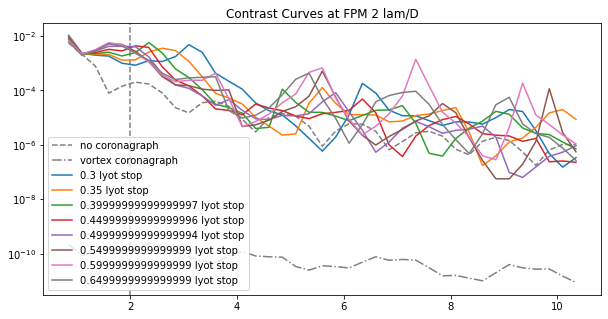

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
#contrast = plt.subplot(1, 2, 1)
#throughput = plt.subplot(1, 2, 2)
#contrast.plot(edges, sums)
plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.axvline(2, linestyle='--', color='gray')

coronagraph = {'fpm_diameter': 2, 'lyot_diameter': .7, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}

lyot_d = np.arange(.3, .7, .05)
for val in lyot_d:
    coronagraph['lyot_diameter'] = val
    lam, contrast = calculate_contrast_curve(coronagraph)
    plt.plot(lam, contrast, label=f'{val} lyot stop')


plt.yscale('log')
plt.title('Contrast Curves at FPM 2 lam/D')
plt.legend()

#throughput.plot(lyot_d, ratios)
#throughput.set_title('Throughput at varying Lyot D')

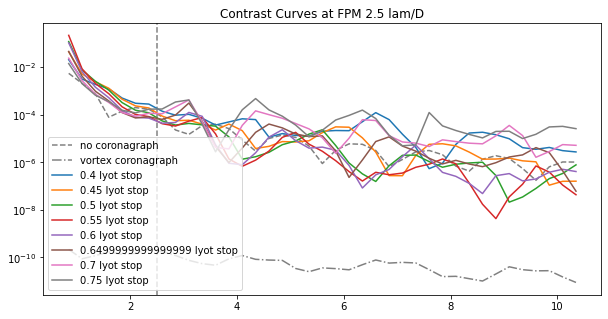

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
#contrast = plt.subplot(1, 2, 1)
#throughput = plt.subplot(1, 2, 2)
#contrast.plot(edges, sums)

plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.axvline(2.5, linestyle='--', color='gray')

coronagraph = {'fpm_diameter': 2.5, 'lyot_diameter': .67, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}

lyot_d = np.arange(.4, .8, .05)
for val in lyot_d:
    coronagraph['lyot_diameter'] = val
    lam, contrast = calculate_contrast_curve(coronagraph)
    plt.plot(lam, contrast, label=f'{val} lyot stop')

plt.yscale('log')
plt.title('Contrast Curves at FPM 2.5 lam/D')
plt.legend()


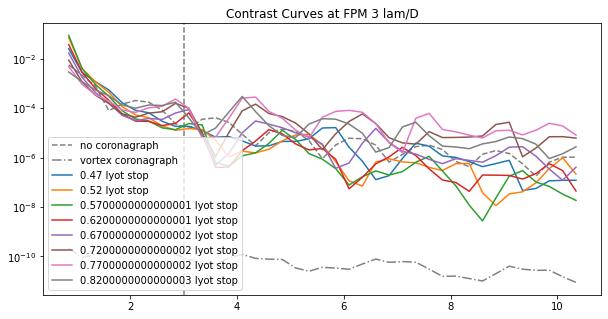

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
#contrast = plt.subplot(1, 2, 1)
#throughput = plt.subplot(1, 2, 2)
#contrast.plot(edges, sums)

coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .67, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}

plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.axvline(3, linestyle='--', color='gray')

lyot_d = np.arange(.47, .87, .05)
for val in lyot_d:
    coronagraph['lyot_diameter'] = val
    lam, contrast = calculate_contrast_curve(coronagraph)
    plt.plot(lam, contrast, label=f'{val} lyot stop')


plt.yscale('log')
plt.title('Contrast Curves at FPM 3 lam/D')
plt.legend()

#throughput.plot(lyot_d, ratios)
#throughput.set_title('Throughput at varying Lyot D')

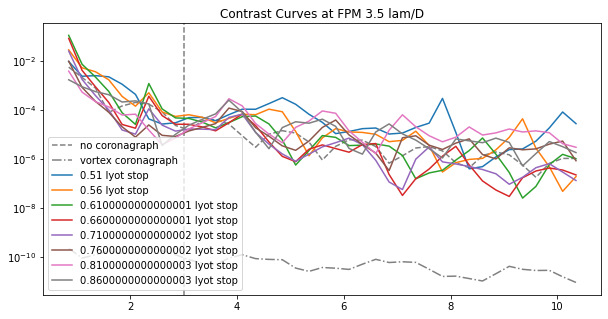

In [13]:
fig, ax = plt.subplots(figsize=(10,5))


coronagraph = {'fpm_diameter': 3.5, 'lyot_diameter': .67, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}

plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.axvline(3, linestyle='--', color='gray')

lyot_d = np.arange(.51, .91, .05)
for val in lyot_d:
    coronagraph['lyot_diameter'] = val
    lam, contrast = calculate_contrast_curve(coronagraph)
    plt.plot(lam, contrast, label=f'{val} lyot stop')

plt.yscale('log')
plt.title('Contrast Curves at FPM 3.5 lam/D')
plt.legend()

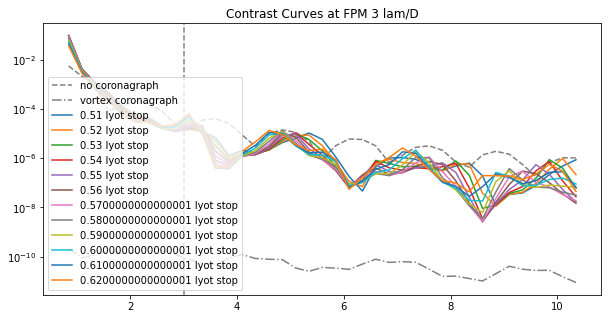

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
#contrast = plt.subplot(1, 2, 1)
#throughput = plt.subplot(1, 2, 2)
#contrast.plot(edges, sums)

coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .67, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}

plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.axvline(3, linestyle='--', color='gray')

lyot_d = np.arange(.51, .63, .01)
for val in lyot_d:
    coronagraph['lyot_diameter'] = val
    lam, contrast = calculate_contrast_curve(coronagraph)
    plt.plot(lam, contrast, label=f'{val} lyot stop')


plt.yscale('log')
plt.title('Contrast Curves at FPM 3 lam/D')
plt.legend()

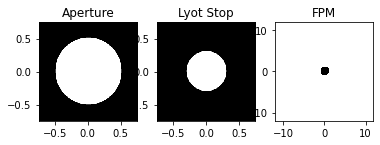

In [15]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(.6), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(3*lam_d), focal_grid, 4)
fpm = fpm_inverse == 0
plt.subplot(1, 3, 1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Lyot Stop')
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('FPM')
imshow_field(fpm, cmap='gray')
plt.show()

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


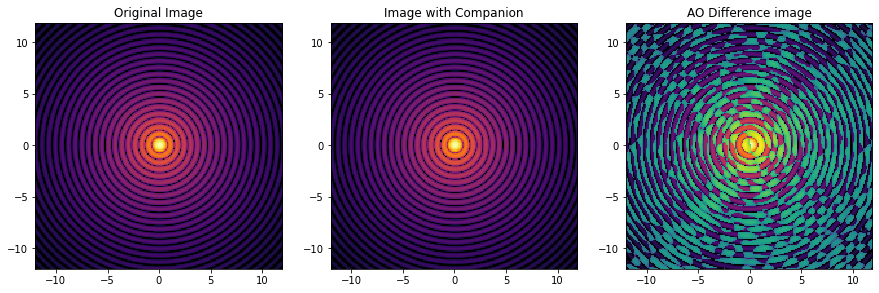

In [61]:
# Time for a companion 
# add placement of companion source as variable 
fig, ax = plt.subplots(figsize=(15,8))
wf = Wavefront(aperture, wavelength=.638)
wf_companion = Wavefront(aperture + aperture * .01 * np.exp(5j * np.pi * pupil_grid.x * 1.5), wavelength=.638)
wf_ao = ao_residuals.forward(wf_companion)
img_ref = prop(wf).intensity
img_ref_ao = prop(wf_ao).intensity
plt.subplot(1, 3, 1)
plt.title('Original Image')
imshow_field(np.log10(img_ref/img_ref.max()), vmin=-6, cmap='inferno')
plt.subplot(1, 3, 2)
plt.title('Image with Companion')
img_ref_companion = prop(wf_companion).intensity
imshow_field(np.log10(img_ref_companion/img_ref_companion.max()), vmin=-6, cmap='inferno')
plt.subplot(1, 3, 3)
plt.title('AO Difference image')
imshow_field(np.log10(img_ref_ao/img_ref_ao.max()), vmin=-6, cmap='inferno')
imshow_field(np.log10(img_ref_companion - img_ref_ao))

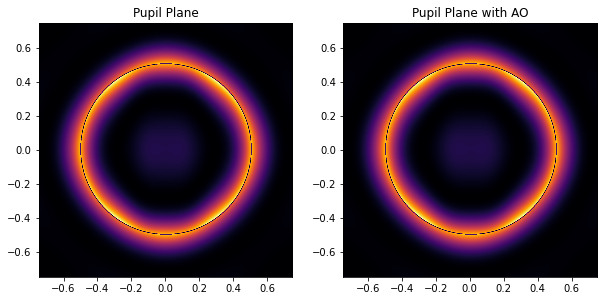

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

lyot_plane = lyot_coro(wf_companion)
lyot_plane_ao = lyot_coro(wf_ao)

plt.subplot(1, 2, 1)
plt.title('Pupil Plane')
imshow_field(lyot_plane.intensity, cmap='inferno')
plt.subplot(1, 2, 2)
plt.title('Pupil Plane with AO')
imshow_field(lyot_plane_ao.intensity, cmap='inferno')

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


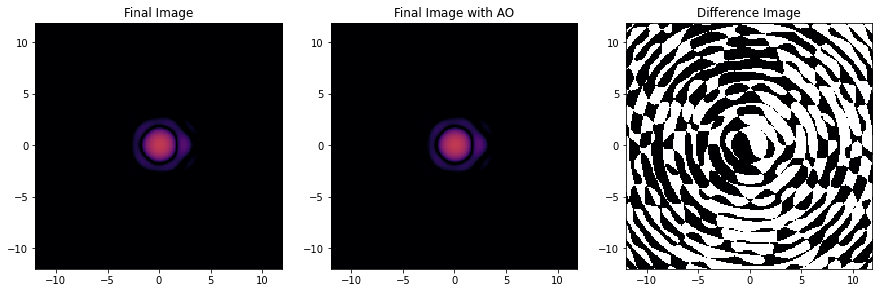

In [75]:
fig, ax = plt.subplots(figsize=(15,10))
post_lyot_mask = lyot_stop(lyot_plane)
post_lyot_mask_ao = lyot_stop(lyot_plane_ao)
img = prop(post_lyot_mask).intensity
img_ao = prop(post_lyot_mask_ao).intensity

plt.subplot(1, 3, 1)

imshow_field(np.log10(img /img_ref_companion.max()), vmin=-6, vmax=0, cmap='inferno')
plt.title('Final Image')

plt.subplot(1, 3, 3)
imshow_field(np.log10(img_ao - img), vmin=-6, vmax=0, cmap='inferno')
plt.title('Difference Image')
plt.subplot(1, 3, 2)
imshow_field(np.log10(img_ao/img_ref_ao.max()), vmin=-6, vmax=0, cmap='inferno')
plt.title('Final Image with AO')


plt.show()

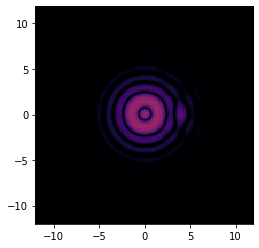

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
img = prop(post_lyot_mask).intensity
imshow_field(np.log10(img /img_ref_companion.max()), vmin=-6, vmax=0, cmap='inferno')
#imshow_field(wf_atm.intensity)

/opt/anaconda3/envs/hicat-package/lib/python3.6/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


Text(0.5, 1.0, 'Testing varying companion brightness')

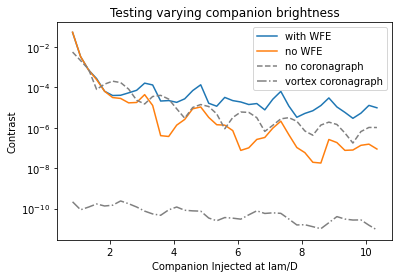

In [19]:
coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .6, 'aperture_type': 'circular', 
               'coronagraph_type': 'lyot', 'companion_brightness': None}
vortex_coronagraph = {'fpm_diameter': 3, 'lyot_diameter': .8, 'aperture_type': 'circular', 
               'coronagraph_type': 'vortex', 'companion_brightness': None}
no_coronagraph = {'fpm_diameter': 0, 'lyot_diameter': 1, 'aperture_type': 'circular', 
                  'coronagraph_type': 'lyot', 'companion_brightness': None}

lam, contrast_wfe = calculate_contrast_curve(coronagraph, include_wfe=True)
lam, contrast = calculate_contrast_curve(coronagraph)
plt.plot(lam, contrast_wfe, label='with WFE')
plt.plot(lam, contrast, label='no WFE')
    
plt.plot(lam, baseline, '--', color='gray', label='no coronagraph')
plt.plot(lam, vortex, '-.', color='gray', label='vortex coronagraph')
plt.legend()
#plt.ylim(10e-11, 10e-5)
plt.yscale('log')
plt.ylabel('Contrast')
plt.xlabel('Companion Injected at lam/D')
plt.title('Testing varying companion brightness')

(0.0110137782784956, 9.185946648708655e-06, 0.000834041363139134)
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   135.0    96.0 0.0110137782784956  id xcenter ycenter      aperture_sum    
      pix     pix                        
--- ------- ------- ---------------------
  1   135.0    96.0 9.185946648708655e-06


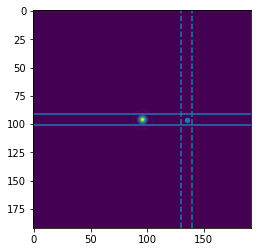

In [20]:
from photutils import aperture_photometry

plt.imshow(img_ref_companion.shaped)
#plt.plot(np.sum(img_ref_companion.shaped, axis=1))
plt.axvline(130, linestyle='--')
plt.axvline(140, linestyle='--')
plt.axhline(91, linestyle='-')
plt.axhline(101, linestyle='-')
plt.scatter(135, 96, s=20)
#plt.plot(np.sum(img_ref.shaped, axis=0))
#plt.plot(img_ref_companion.shaped[86,:])
#plt.plot(img_ref_companion.shaped[:, 86])
cut = img_ref_companion.shaped[91:101, 130:140]
cut_corona = img.shaped[91:101, 130:140]

corona_aperture, radius = (135, 96), 5
phot_aperture = CircularAperture([corona_aperture], r=radius)
phot_before = aperture_photometry(img_ref_companion.shaped, phot_aperture)
phot_after = aperture_photometry(img.shaped, phot_aperture)
print(calculate_throughput(img_ref_companion.shaped, img.shaped))
print(phot_before, phot_after)

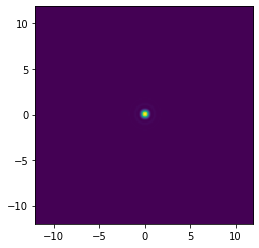

In [21]:
imshow_field(img_ref)

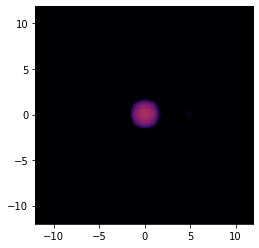

In [22]:
fpm_d = 2.7*lam_d
lyot_d = .6
cg_data, data_max, field_img, companion_img = generate_coronagraph(fpm_d, lyot_d, aperture_type='circular', plot=True)

In [23]:
# for lenox reflective, 10% tol
# D : 1 (um)--> 3.5 mm
# ex FPM D : 3 * .638 / 1 --> 3 .638/3500
3 * .648/35000 # this is in radians 
# use f# of system to convert ~ 40 perhaps? 

5.5542857142857143e-05

(0.0110137782784956, 9.185946648708655e-06, 0.000834041363139134)
 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1   135.0    96.0 0.0110137782784956  id xcenter ycenter      aperture_sum    
      pix     pix                        
--- ------- ------- ---------------------
  1   135.0    96.0 9.185946648708655e-06


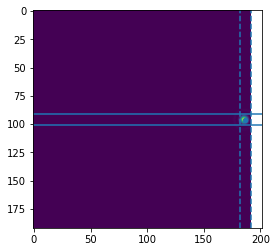

In [24]:
wf = Wavefront(aperture * .01 * np.exp(35j * np.pi * pupil_grid.x), wavelength=.638)
img_ref = prop(wf).intensity
#imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5, cmap='inferno')

plt.imshow(img_ref.shaped)
#plt.plot(np.sum(img_ref_companion.shaped, axis=1))
plt.axvline(182, linestyle='--')
plt.axvline(192, linestyle='--')
plt.axhline(91, linestyle='-')
plt.axhline(101, linestyle='-')
plt.scatter(186, 96, s=20)
#plt.plot(np.sum(img_ref.shaped, axis=0))
#plt.plot(img_ref_companion.shaped[86,:])
#plt.plot(img_ref_companion.shaped[:, 86])
cut = img_ref_companion.shaped[91:101, 182:192]
cut_corona = img.shaped[91:101, 182:192]

corona_aperture, radius = (135, 96), 5
phot_aperture = CircularAperture([corona_aperture], r=radius)
phot_before = aperture_photometry(img_ref_companion.shaped, phot_aperture)
phot_after = aperture_photometry(img.shaped, phot_aperture)
print(calculate_throughput(img_ref_companion.shaped, img.shaped))
print(phot_before, phot_after)

In [25]:
img_ref.shaped.shape

(192, 192)

In [26]:
# pixel - 1j step converstion : 
pixel_to_j = (186-96)/35
(annulus_width/pixel_to_j)
# move by 2.4j at a time to match to lambda/d?

NameError: name 'annulus_width' is not defined

In [ ]:
annulus_width = lam_d/2*(192/10)
annulus_width

In [ ]:
np.arange(4, 25, annulus_width/pixel_to_j)

In [ ]:
pixel_to_j*35+192/2

In [ ]:
var = 3
complex(0, var)

In [ ]:
aberration = SurfaceAberration(pupil_grid, .1, 1, exponent=-2)
# power law PSD 
# what does exponent map toooo? 
# when we figure that out what's reasonable for our system...
wf = Wavefront(aperture)
img = prop(aberration(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

In [ ]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(circular_aperture(.8), pupil_grid, 4)
fpm_inverse = evaluate_supersampled(circular_aperture(5*lam_d), focal_grid, 4)
fpm = fpm_inverse == 0
fpm2_inverse = evaluate_supersampled(circular_aperture(5.5*lam_d), focal_grid, 4)
fpm2 = fpm2_inverse == 0
wonky_fpm = fpm*np.random.randint(0,2, size=(36864,)) + fpm2
wonky_fpm[wonky_fpm > 1] = 1
imshow_field(wonky_fpm)
plt.subplot(1, 3, 1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Lyot Stop')
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('FPM')
imshow_field(wonky_fpm, cmap='gray')
plt.show()

In [ ]:
imshow_field(wonky_fpm, cmap='gray')
plt.show()

In [ ]:
# Time for a companion 
# add placement of companion source as variable 
wf = Wavefront(aperture, wavelength=.638)
wf_companion = Wavefront(aperture + aperture * .01 * np.exp(10j * np.pi * pupil_grid.x * 1.5), wavelength=.638)
img_ref = prop(wf).intensity
plt.subplot(1, 2, 1)
plt.title('Original Image')
imshow_field(np.log10(img_ref/img_ref.max()), vmin=-5, cmap='inferno')
plt.subplot(1, 2, 2)
plt.title('Image with Companion')
img_ref_companion = prop(wf_companion).intensity
imshow_field(np.log10(img_ref_companion/img_ref_companion.max()), vmin=-5, cmap='inferno')

In [ ]:
lyot_coro_wonky = LyotCoronagraph(pupil_grid, wonky_fpm)
lyot_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

lyot_plane_wonky = lyot_coro_wonky(wf_companion)
lyot_plane = lyot_coro(wf_companion)

plt.subplot(1, 2, 1)
plt.title('Perfect FPM')
imshow_field(lyot_plane.intensity, cmap='inferno', vmin=0, vmax=.03)
plt.subplot(1, 2, 2)
plt.title('Wonky FPM')
imshow_field(lyot_plane_wonky.intensity, cmap='inferno', vmin=0, vmax=.03)

In [ ]:
post_lyot_mask = lyot_stop(lyot_plane)
post_lyot_mask_wonky = lyot_stop(lyot_plane_wonky)
img = prop(post_lyot_mask).intensity
img_wonky = prop(post_lyot_mask_wonky).intensity

plt.gcf().set_size_inches(11,8)
plt.subplot(1, 2, 1)
plt.title('Perfect FPM')
imshow_field(np.log10(img /img_ref_companion.max()), vmin=-10, vmax=.01, cmap='inferno')
plt.subplot(1, 2, 2)
plt.title('Wonky FPM')
imshow_field(np.log10(img_wonky /img_ref_companion.max()), vmin=-10, vmax=.01, cmap='inferno')
plt.show()

In [40]:
fried_parameter = 0.12 #meter
outer_scale = 50 #meter
vx, vy = 1, 1
velocity = np.sqrt(vx*2+vy*2) # m/s
cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, cn_squared, outer_scale, velocity)

#num_modes = 121 # number DM actuators 
num_modes = 5
telescope_diameter=1
controlled_modes = make_zernike_basis(num_modes, telescope_diameter, pupil_grid)
controlled_modes_121 = make_zernike_basis(121, telescope_diameter, pupil_grid)
controlled_modes_300 = make_zernike_basis(300, telescope_diameter, pupil_grid)
lag=0

ao_residuals = ModalAdaptiveOpticsLayer(layer, controlled_modes, lag)
ao_residuals.evolve_until(0)
wf_atm = ao_residuals.forward(wf)

ao_residuals_121 = ModalAdaptiveOpticsLayer(layer, controlled_modes_121, lag)
ao_residuals_300 = ModalAdaptiveOpticsLayer(layer, controlled_modes_300, lag)

#ao_residuals.t = time[ccc]
#wf_atm = ao_residuals.forward(wf)
#phase = rp(ao_residuals.phase_for(wavelength))*tel_aperture

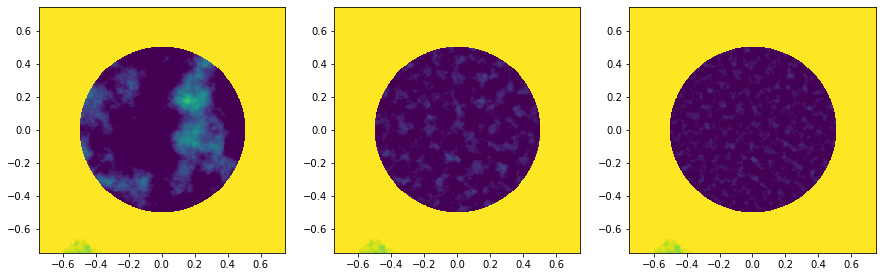

In [42]:
#ao_residuals_50.evolve_until(0)
ao_residuals_121.evolve_until(0)
ao_residuals_300.evolve_until(0)

plt.gcf().set_size_inches(15,8)
plt.subplot(1, 3, 1)
imshow_field(ao_residuals.phase_for(wavelength), vmin=0, vmax=5)
plt.subplot(1, 3, 2)
imshow_field(ao_residuals_121.phase_for(wavelength), vmin=0, vmax=5)
plt.subplot(1, 3, 3)
imshow_field(ao_residuals_300.phase_for(wavelength), vmin=0, vmax=5)

#wf_atm = ao_residuals.forward(wf)
#imshow_field(wf_atm.intensity)
#imshow_field(wf_atm)